In [772]:
import sklearn
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from statistics import median, mean
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier,RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import RocCurveDisplay
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [773]:
dir = "data/"

employee_survey = pd.read_csv(dir + "employee_survey_data.csv")
general = pd.read_csv(dir + "general_data.csv")
manager_survey = pd.read_csv(dir + "manager_survey_data.csv")
in_time = pd.read_csv(dir + "in_time.csv")
out_time = pd.read_csv(dir + "out_time.csv")

# Sommaire

<ul>
    <li><a href="#es">Employe survey</a></li>
    <li><a href="#ge">General</a></li>
    <li><a href="#ms">Manager survey</a></li>
    <li><a href="#it">In Time</a></li>
    <li><a href="#ot">Out Time</a></li>
    <li><a href="#ld">Lien entre les dataset</a></li>
    <li><a href="#cc">Conclusion</a></li>
</ul>

# Définition des variables globales

In [774]:
nbEmploye = employee_survey["EmployeeID"].max()
print("Il y a", nbEmploye, "employés dans le dataset")

Il y a 4410 employés dans le dataset


# Pré-analyse des données
<div id="es"></div>

## Employee_survey.csv

### Données contenues dans le set

In [775]:
employee_survey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [776]:
employee_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB


### Anaylse des données vides

In [777]:
employee_survey.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

### Répartition des notes

<AxesSubplot:>

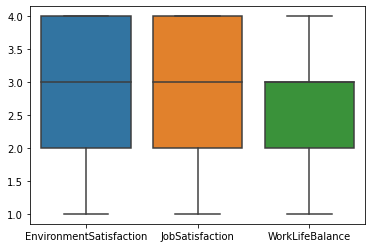

In [778]:
employee_survey_anonyme = employee_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=employee_survey_anonyme)


<AxesSubplot:ylabel='Count'>

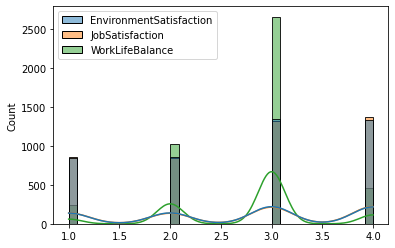

In [779]:
sns.histplot(data=employee_survey_anonyme, kde=True)

### Tendance des mauvais résultats

On regarde tout d'abord le nombre de gens qui sont insatisfait le l'environnement de travail et on remarque qu'ils représentent 38,5% des employés

In [780]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1].count()
print(BadEnvironmentSatisfaction['EnvironmentSatisfaction'] / nbEmploye * 100)
BadEnvironmentSatisfaction


38.57142857142858


EmployeeID                 1701
EnvironmentSatisfaction    1701
JobSatisfaction            1694
WorkLifeBalance            1685
dtype: int64

On fait la même chose pour la satisfaction sur leurs travail et on obtient des résultats similaires, ce qui confirme les boîtes a moustache

In [781]:
BadJobSatisfaction = employee_survey[employee_survey['JobSatisfaction']<2.1].count()
print(BadJobSatisfaction['JobSatisfaction'] / nbEmploye * 100)
BadJobSatisfaction

38.54875283446712


EmployeeID                 1700
EnvironmentSatisfaction    1694
JobSatisfaction            1700
WorkLifeBalance            1687
dtype: int64

Enfin on regarde l'équilibre entre la vie privée et professionelle, dans ce cas on obtient 28.5% des employés

In [782]:
BadWorkLifeBalance = employee_survey[employee_survey['WorkLifeBalance']<2.1].count()
print(BadWorkLifeBalance['WorkLifeBalance'] / nbEmploye * 100)
BadWorkLifeBalance

28.52607709750567


EmployeeID                 1258
EnvironmentSatisfaction    1250
JobSatisfaction            1254
WorkLifeBalance            1258
dtype: int64

Si on essaie de regarder les employés qui une balance mauvaise, et une satisfaction de leur travail et de leur environnement de travail faible on obtient 178 personne avec une très mauvaise expérience

In [783]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1]
BadSatisfaction = BadEnvironmentSatisfaction[BadEnvironmentSatisfaction['JobSatisfaction']<2.1]
BadAll = BadSatisfaction[BadSatisfaction['WorkLifeBalance']<2.1]
BadAll["EmployeeID"].count()

178

## General.csv
<div id="ge"></div>

### Données contenue dans le set

In [784]:
general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [785]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### Analyse des données vides

In [786]:
general.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

### Analyse générales

#### Nombres de personnes qui ont quitté l'entreprise en 2016

In [787]:
peopleLeft = general[general["Attrition"] == 1]
print("Number of people who left the company:", peopleLeft.shape[0], "out of", general.shape[0], "employees")
print("Approx", round(peopleLeft.shape[0] / general.shape[0] * 100, 2), "% of the employees left the company")

Number of people who left the company: 0 out of 4410 employees
Approx 0.0 % of the employees left the company


### Histogrammes

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>,
        <AxesSubplot:title={'center':'Education'}>],
       [<AxesSubplot:title={'center':'JobLevel'}>,
        <AxesSubplot:title={'center':'MonthlyIncome'}>,
        <AxesSubplot:title={'center':'NumCompaniesWorked'}>],
       [<AxesSubplot:title={'center':'PercentSalaryHike'}>,
        <AxesSubplot:title={'center':'TotalWorkingYears'}>,
        <AxesSubplot:title={'center':'TrainingTimesLastYear'}>],
       [<AxesSubplot:title={'center':'YearsAtCompany'}>,
        <AxesSubplot:title={'center':'YearsSinceLastPromotion'}>,
        <AxesSubplot:title={'center':'YearsWithCurrManager'}>]],
      dtype=object)

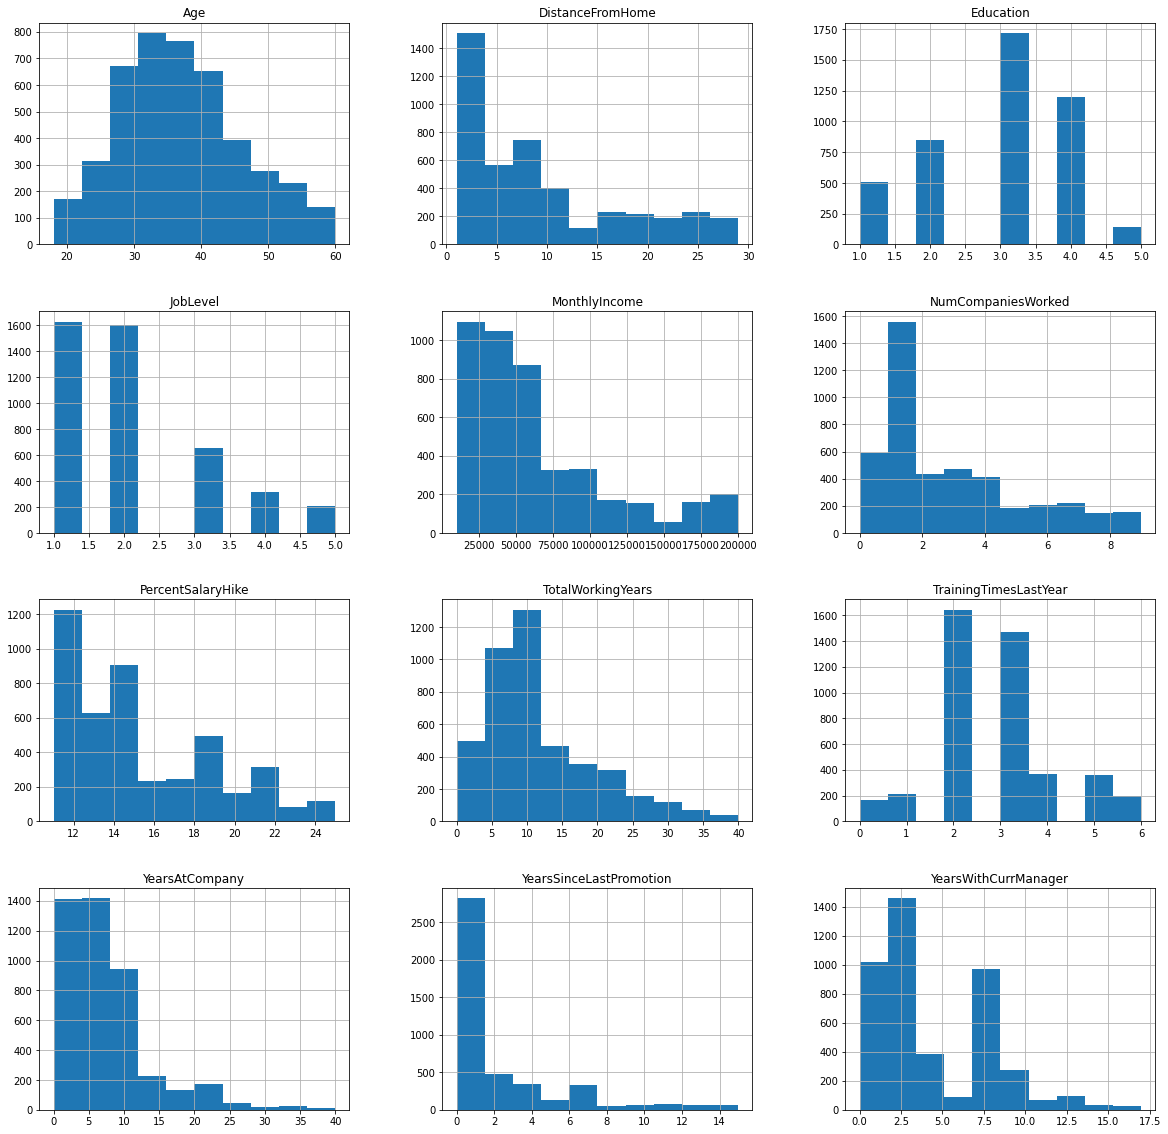

In [788]:
general.filter(items= ["Age","DistanceFromHome","Education","JobLevel", "MonthlyIncome", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]).hist(figsize=(20,20))

## Manager survey.csv
<div id="ms"></div>

### Données contenue dans le set

In [789]:
manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [790]:
manager_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB


### Analyse des données vides

In [791]:
manager_survey.isnull().sum()

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

### Analyse générale

<AxesSubplot:>

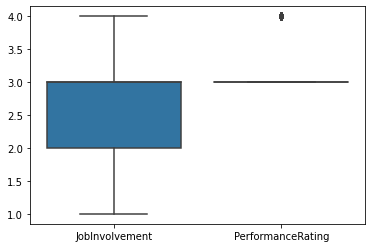

In [792]:
manager_survey_anonyme = manager_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=manager_survey_anonyme)

## In Time.csv
<div id="it"></div>

### Données contenues dans le dataset

In [793]:
in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


### Analyse des données vides

In [794]:
print("Par date")
print(in_time.isnull().sum())
print("Par employé")
print(in_time.isnull().sum(axis=1))

Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


### Répartition des données

<AxesSubplot:>

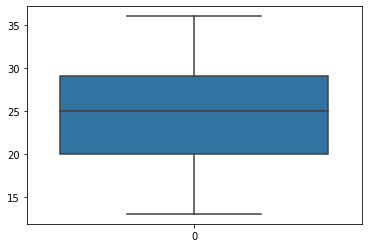

In [795]:

sns.boxplot(in_time.isnull().sum(axis=1))

## Out Time.csv
<div id="ot"></div>

### Données contenues dans le set

In [796]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


### Analyse des données vides

In [797]:
print("Par date")
print(out_time.isnull().sum())
print("Par employé")
print(out_time.isnull().sum(axis=1))


Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


### Répartition des données

<AxesSubplot:>

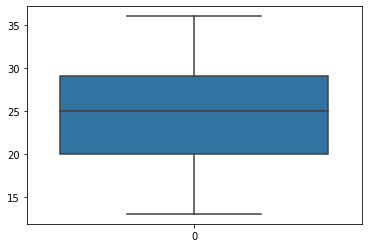

In [798]:

sns.boxplot(in_time.isnull().sum(axis=1))

# Préparation des données

## Numérisation

#### Variables discrètes hierarchiques

Ensuite, on remplace les valeurs dans "BusinessTravel" avec l'"OrdinalEncoder" car il y a un ordre hiérarchique entre les données

In [799]:
ord_enc = OrdinalEncoder(categories=[['Non-Travel','Travel_Rarely','Travel_Frequently']])
encoded = ord_enc.fit_transform(general[["BusinessTravel"]])
general.drop('BusinessTravel', axis=1)
general = general.assign(BusinessTravel = encoded) 

In [800]:
ord_enc = OrdinalEncoder(categories=[['No','Yes']])
encoded = ord_enc.fit_transform(general[["Attrition"]])
general.drop('Attrition', axis=1)
general = general.assign(Attrition = encoded) 

In [801]:
ord_enc = OrdinalEncoder(categories=[['N','Y']])
encoded = ord_enc.fit_transform(general[["Over18"]])
general.drop('Over18', axis=1)
general = general.assign(Over18 = encoded) 

#### Variables discrètes indépendantes
Ensuite on remplace les valeurs dans "Department" avec le "OneHotEncoder" car il n'y a pas de hiérarchie entre les valeurs

In [802]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Department']])
dpt_enc = pd.DataFrame(encoded.toarray())
dpt_enc = dpt_enc.rename(columns={0:'Department_HR', 1:'Department_Research & Development', 2:'Department_Sales'})
general.drop('Department', axis=1, inplace=True)
general = pd.concat([general, dpt_enc], axis=1)

In [803]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['EducationField']])
edu_enc = pd.DataFrame(encoded.toarray())
edu_enc = edu_enc.rename(columns={
    0:'Education_Human Resources', 
    1:'Education_Life Sciences', 
    2:'Education_Marketing', 
    3:'Education_Medical', 
    4:'Education_Other', 
    5:'Education_Technical Degreee'})
general.drop('EducationField', axis=1, inplace=True)
general = pd.concat([general, edu_enc], axis=1)

In [804]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Gender']])
gen_enc = pd.DataFrame(encoded.toarray())
gen_enc = gen_enc.rename(columns={0:'Female', 1:'Male'})
general.drop('Gender', axis=1, inplace=True)
general = pd.concat([general, gen_enc], axis=1)

In [805]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['JobRole']])
job_enc = pd.DataFrame(encoded.toarray())
job_enc = job_enc.rename(columns={
    0:'Job_Healthcare Representative', 
    1:'Job_Human Resources', 
    2:'Job_Laboratory Technician', 
    3:'Job_Manager', 
    4:'Job_Manufacturing Director',
    5:'Job_Research Director',
    6:'Job_Research Scientist',
    7:'Job_Sales Executive',
    8:'Job_Sales Representative'})
general.drop('JobRole', axis=1, inplace=True)
general = pd.concat([general, job_enc], axis=1)

In [806]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['MaritalStatus']])
mar_enc = pd.DataFrame(encoded.toarray())
mar_enc = mar_enc.rename(columns={0:'Divorced', 1:'Married', 2:'Single'})
general.drop('MaritalStatus', axis=1, inplace=True)
general = pd.concat([general, mar_enc], axis=1)

In [807]:
general

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,...,Job_Laboratory Technician,Job_Manager,Job_Manufacturing Director,Job_Research Director,Job_Research Scientist,Job_Sales Executive,Job_Sales Representative,Divorced,Married,Single
0,51,0.0,1.0,6,2,1,1,1,131160,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,31,1.0,2.0,10,1,1,2,1,41890,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,32,0.0,2.0,17,4,1,3,4,193280,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,38,0.0,0.0,2,5,1,4,3,83210,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,32,0.0,1.0,10,1,1,5,1,23420,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0.0,1.0,5,4,1,4406,1,60290,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4406,29,0.0,1.0,2,4,1,4407,1,26790,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4407,25,0.0,1.0,25,2,1,4408,2,37020,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4408,42,0.0,1.0,18,2,1,4409,1,23980,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [808]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   int64  
 1   Attrition                          4410 non-null   float64
 2   BusinessTravel                     4410 non-null   float64
 3   DistanceFromHome                   4410 non-null   int64  
 4   Education                          4410 non-null   int64  
 5   EmployeeCount                      4410 non-null   int64  
 6   EmployeeID                         4410 non-null   int64  
 7   JobLevel                           4410 non-null   int64  
 8   MonthlyIncome                      4410 non-null   int64  
 9   NumCompaniesWorked                 4391 non-null   float64
 10  Over18                             4410 non-null   float64
 11  PercentSalaryHike                  4410 non-null   int64

## Création d'attributs

### Temps de travail moyen

<AxesSubplot:>

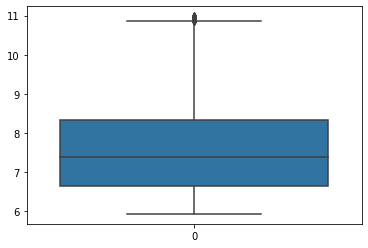

In [809]:
# average of the number of hours worked per day
in_time = in_time.dropna(axis=1, how='all')
out_time = out_time.dropna(axis=1, how='all')
in_time = in_time.dropna(axis=0, how='all')
out_time = out_time.dropna(axis=0, how='all')
in_time = in_time.apply(pd.to_datetime)
out_time = out_time.apply(pd.to_datetime)
hours_worked = out_time - in_time
hours_worked = hours_worked.applymap(lambda x: x.total_seconds() / 3600)
hours_worked = hours_worked.mean(axis=1)
hours_worked = hours_worked.dropna()
hours_worked = hours_worked.reset_index(drop=True)
sns.boxplot(hours_worked)



In [810]:
hours_worked_df = pd.DataFrame({
    "EmployeeID": general["EmployeeID"],
    "avg_hours_worked": hours_worked })
hours_worked_df

,EmployeeID,avg_hours_worked
0,1,7.342004
1,2,7.686399
2,3,6.984379
3,4,7.163197
4,5,7.973629
...,...,...
4405,4406,8.487350
4406,4407,6.067777
4407,4408,7.673414
4408,4409,9.453369


On remarque un taux plus élevé de démissions chez les gens qui travaillent le plus

<AxesSubplot:xlabel='avg_hours_worked', ylabel='Count'>

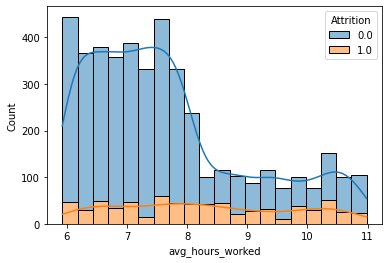

In [811]:
general_time = general.merge(hours_worked_df, on="EmployeeID")

sns.histplot(data=general_time, x="avg_hours_worked", hue="Attrition", multiple="stack", bins=20, kde=True)

In [812]:
general_badAll = general_time.merge(BadAll, on="EmployeeID", copy=True)

(general_badAll["Attrition"] == 0).sum()

133

### Heure moyenne de départ

In [813]:
out_timeAverage = out_time[out_time.columns[1:]].apply(pd.to_datetime)
out_timeAverage = out_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
out_timeAverage  = out_timeAverage.mean(axis=1)
out_timeAverage = out_timeAverage.to_frame()
out_timeAverage = out_timeAverage.assign(EmployeeID=range(1, len(out_timeAverage)+1))
out_timeAverage = out_timeAverage.rename(columns={0: 'avg_out_time'})

### Heure moyenne d'arrivé

In [814]:
in_timeAverage = in_time[in_time.columns[1:]].apply(pd.to_datetime)
in_timeAverage = in_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
in_timeAverage = in_timeAverage.mean(axis=1)
in_timeAverage = in_timeAverage.to_frame()
in_timeAverage = in_timeAverage.assign(EmployeeID=range(1, len(in_timeAverage)+1))
in_timeAverage = in_timeAverage.rename(columns={0:'AverageStartTime'})

## Fusion des differents dataframes

In [815]:
all_data = general.merge(manager_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(employee_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(hours_worked_df, on="EmployeeID", copy=True)
all_data = all_data.merge(out_timeAverage, on="EmployeeID", copy=True)
all_data = all_data.merge(in_timeAverage, on="EmployeeID", copy=True)

## Data cleaning

On regarde si certaines données peuvent être supprimées 

In [816]:
print(all_data["EmployeeID"].unique())
print(all_data["Over18"].unique())
print(all_data["StandardHours"].unique())

[   1    2    3 ... 4408 4409 4410]
[1.]
[8]


In [817]:
def dataCleaning(all_data, type):
    if type == 1:
        # drop useless columns
        all_data.drop("EmployeeID", axis=1, inplace=True)
        all_data.drop("Over18", axis=1, inplace=True)
        all_data.drop("EmployeeCount", axis=1, inplace=True)
        all_data.drop("StandardHours", axis=1, inplace=True)

    if type == 2:
        # drop unethical columns
        all_data.drop("Male", axis=1, inplace=True)
        all_data.drop("Female", axis=1, inplace=True)
        all_data.drop("Single", axis=1, inplace=True)
        all_data.drop("Married", axis=1, inplace=True)
        all_data.drop("Divorced", axis=1, inplace=True)
        all_data.drop("Age", axis=1, inplace=True)

    return all_data

all_data = dataCleaning(all_data,1)

Lien entre age et temps travaillé

In [818]:
all_data = dataCleaning(all_data,2)

## Gestion des valeurs manquantes

In [819]:
def nullToMedian(all_data):
    all_data["NumCompaniesWorked"] = all_data["NumCompaniesWorked"].replace(np.nan,median(all_data["NumCompaniesWorked"]))
    all_data["TotalWorkingYears"] = all_data["TotalWorkingYears"].replace(np.nan,median(all_data["TotalWorkingYears"]))

    all_data["EnvironmentSatisfaction"] = all_data["EnvironmentSatisfaction"].replace(np.nan,median(all_data["EnvironmentSatisfaction"]))
    all_data["JobSatisfaction"] = all_data["JobSatisfaction"].replace(np.nan,median(all_data["JobSatisfaction"]))
    all_data["WorkLifeBalance"] = all_data["WorkLifeBalance"].replace(np.nan,median(all_data["WorkLifeBalance"]))
    return all_data

def nullToKnnImputer(all_data):
    imputer = KNNImputer(n_neighbors=5)
    all_data_imputed = pd.DataFrame(imputer.fit_transform(all_data), columns=all_data.columns)
    return all_data_imputed

all_data = nullToKnnImputer(all_data)

## Normalisation des données

In [820]:
min_max_scaler = lambda x: (x-x.min()) / (x.max()-x.min())
all_data = all_data.apply(min_max_scaler)
all_data

,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,Job_Sales Executive,Job_Sales Representative,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,avg_hours_worked,avg_out_time,AverageStartTime
0,0.0,0.5,0.178571,0.25,0.00,0.637546,0.111111,0.000000,0.000000,0.025,...,0.0,0.0,0.666667,0.0,0.666667,1.000000,0.333333,0.280179,0.278397,0.455440
1,1.0,1.0,0.321429,0.00,0.00,0.167457,0.000000,0.857143,0.333333,0.150,...,0.0,0.0,0.333333,1.0,0.666667,0.333333,1.000000,0.348247,0.343277,0.360231
2,0.0,1.0,0.571429,0.75,0.75,0.964666,0.111111,0.285714,1.000000,0.125,...,1.0,0.0,0.666667,0.0,0.333333,0.333333,0.000000,0.209497,0.212578,0.624032
3,0.0,0.0,0.035714,1.00,0.50,0.385045,0.333333,0.000000,1.000000,0.325,...,0.0,0.0,0.333333,0.0,1.000000,1.000000,0.666667,0.244839,0.239394,0.315702
4,0.0,0.5,0.321429,0.00,0.00,0.070195,0.444444,0.071429,0.666667,0.225,...,1.0,0.0,0.666667,0.0,1.000000,0.000000,0.666667,0.405016,0.401445,0.434548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.0,0.5,0.142857,0.75,0.00,0.264350,0.333333,0.428571,0.333333,0.250,...,0.0,0.0,0.666667,0.0,1.000000,0.000000,0.666667,0.506549,0.506475,0.586438
4406,0.0,0.5,0.035714,0.75,0.00,0.087941,0.222222,0.285714,0.000000,0.250,...,0.0,0.0,0.333333,0.0,1.000000,1.000000,0.666667,0.028336,0.028650,0.475596
4407,0.0,0.5,0.857143,0.25,0.25,0.141811,0.000000,0.642857,0.000000,0.125,...,1.0,0.0,0.666667,1.0,0.000000,0.666667,0.666667,0.345680,0.339283,0.302463
4408,0.0,0.5,0.607143,0.25,0.00,0.073144,0.000000,0.214286,0.333333,0.250,...,0.0,0.0,0.333333,0.0,1.000000,0.000000,0.666667,0.697477,0.695871,0.577572


## Selection des caractéristiques et split de nos données

Le test du khi2 permet d'identifier les caractéristiques les plus pertinentes pour un modèle en évaluant leur indépendance par rapport à la variable cible.

In [821]:
# Préparer les données
y = all_data["Attrition"]
X = all_data.drop(columns=["Attrition"])

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [822]:
# Sélection des caractéristiques avec le test du khi2
k_best = SelectKBest(chi2, k="all")  # Utilisez un nombre approprié pour 'k' en fonction de vos données
X_train_kbest = k_best.fit_transform(x_train, y_train)
X_test_kbest = k_best.transform(x_test)

In [823]:
# Choisir un modèle (ici, nous utilisons la régression logistique)
model = LogisticRegression()

# Liste pour stocker les scores de validation croisée
cv_scores = []

In [824]:
max_features = x_train.shape[1]

# Boucle sur différentes valeurs de k
for k in range(1, max_features + 1):
    # Sélection des k meilleures caractéristiques
    k_best = SelectKBest(chi2, k=k)
    X_train_kbest = k_best.fit_transform(x_train, y_train)
    
    # Évaluation du modèle avec validation croisée k-fold (k = 5)
    scores = cross_val_score(model, X_train_kbest, y_train, cv=5)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)

# Trouver la valeur de k avec la meilleure performance
best_k = np.argmax(cv_scores) + 1
print(f"La meilleure valeur de k est {best_k}")

La meilleure valeur de k est 37


Nous avons donc déterminé que la valeur optimale de k est 21, nous garderons donc les 21 caractéristiques les plus importantes. Déterminons maintenant nos données finales à utiliser dans nos modèles.

In [825]:
# Sélection des caractéristiques avec le test du khi2
k_best = SelectKBest(chi2, k=best_k)
X_train_kbest = k_best.fit_transform(x_train, y_train)
X_test_kbest = k_best.transform(x_test)

# Récupérer les noms de colonnes sélectionnés
selected_features = x_train.columns[k_best.get_support()]

In [826]:
# Convertir les tableaux NumPy en DataFrames pandas avec les noms de colonnes appropriés
x_train = pd.DataFrame(X_train_kbest, columns=selected_features)
x_test = pd.DataFrame(X_test_kbest, columns=selected_features)

# Analyse et relation entre nos données

<AxesSubplot:>

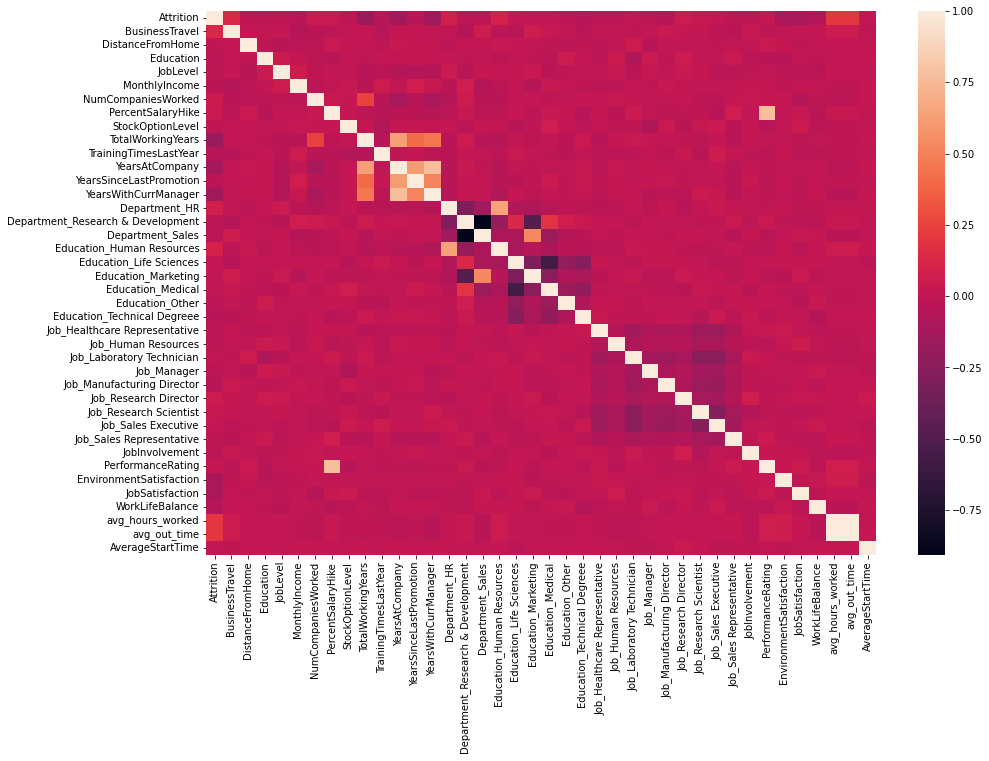

In [827]:
plt.figure(figsize=(15, 10))
sns.heatmap(all_data.corr())

<AxesSubplot:>

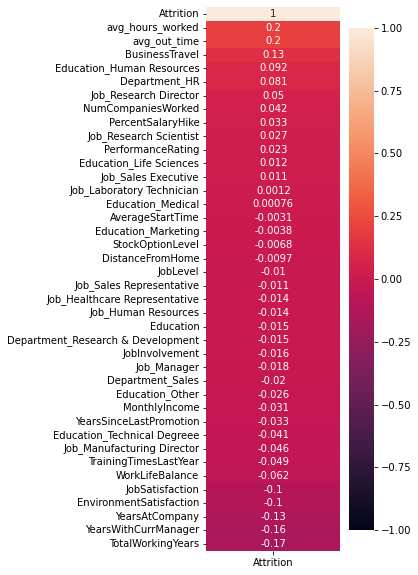

In [828]:
plt.figure(figsize=(3, 10))
all_data_corr = all_data.corr()
sns.heatmap(all_data_corr[['Attrition']].sort_values(by=['Attrition'],ascending=False), vmin=-1, vmax=1, annot=True)

# Test des différents modèles

In [829]:
def score(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("ROC AUC score:", roc_auc_score(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_test, y_pred))
    roc_display.plot()
    plt.show()

## Choix des hyperparamètres

### DecisionTreeClassifier

Pour le DecisionTreeClassifier nous allons utiliser GridSearch afin de trouver les meilleurs hyperparamètres

In [830]:
pipeline_dtc = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

In [831]:
criterion = ['gini', 'entropy']
max_depth = [16,18,20,21,22,23,24,30]
splitter = ['best','random']


parameters_dtc = dict(classifier__criterion=criterion,
                  classifier__max_depth=max_depth,
                  classifier__splitter=splitter)


In [832]:
dtc_GS = GridSearchCV(pipeline_dtc, parameters_dtc, cv=7)
dtc_GS.fit(x_train, y_train)

dtc_GS.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 30,
 'classifier__splitter': 'random'}

In [833]:
pd.DataFrame.from_dict(dtc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
15,0.009478,0.000780,0.001569,0.000495,gini,30,random,"{'classifier__criterion': 'gini', 'classifier_...",0.973881,0.983209,0.972015,0.977570,0.990654,0.985047,0.986916,0.981327,0.006457,1
5,0.009497,0.000418,0.001385,0.000460,gini,20,random,"{'classifier__criterion': 'gini', 'classifier_...",0.975746,0.964552,0.988806,0.983178,0.983178,0.990654,0.979439,0.980793,0.008141,2
1,0.009265,0.000619,0.001423,0.000493,gini,16,random,"{'classifier__criterion': 'gini', 'classifier_...",0.962687,0.979478,0.979478,0.966355,0.988785,0.983178,0.985047,0.977858,0.009001,3
23,0.009951,0.000768,0.001951,0.000112,entropy,21,random,"{'classifier__criterion': 'entropy', 'classifi...",0.975746,0.972015,0.983209,0.966355,0.986916,0.977570,0.981308,0.977589,0.006471,4
29,0.009983,0.000535,0.001706,0.000458,entropy,24,random,"{'classifier__criterion': 'entropy', 'classifi...",0.962687,0.981343,0.972015,0.964486,0.986916,0.979439,0.985047,0.975990,0.009001,5


Accuracy: 0.9879154078549849
F1 score: 0.9626168224299065
Precision: 0.9626168224299065
Recall: 0.9626168224299065
ROC AUC score: 0.9777048076113496


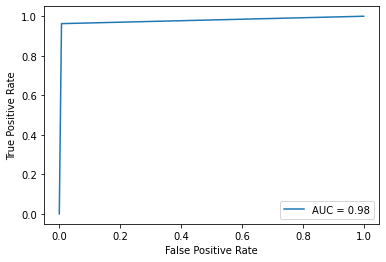

In [834]:
dtc = DecisionTreeClassifier(criterion = dtc_GS.best_params_['classifier__criterion'], max_depth = dtc_GS.best_params_['classifier__max_depth'], splitter = dtc_GS.best_params_['classifier__splitter'])

dtc.fit(x_train, y_train)

y_pred_dtc = dtc.predict(x_test)

score(y_test, y_pred_dtc)

Après plusieurs tests, on ressort qu'une max_depth de 22 et un criterion en entropy est le meilleur model que l'on peu avoir

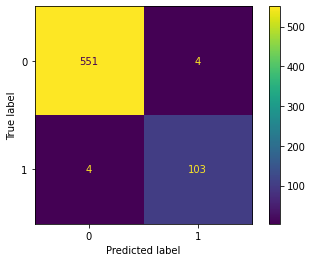

In [835]:
dtc_cm = confusion_matrix(y_test, y_pred_dtc)
dtc_cmd = ConfusionMatrixDisplay(confusion_matrix=dtc_cm,
                       display_labels=[0,1])

dtc_cmd.plot()
plt.show()


### HistGradientBoostingClassifier

In [836]:
pipeline_hgbc = Pipeline(steps=[
    ('classifier', HistGradientBoostingClassifier())
])

In [837]:
learning_rate = [0.1,0.2,0.3]
max_depth = [10,15,20,30]
loss = ['log_loss']
max_iter = [10,20,50,100,200]

parameters_hgbc = dict(classifier__learning_rate=learning_rate,
                  classifier__max_depth=max_depth,
                  classifier__loss=loss,
                  classifier__max_iter=max_iter
                  )

In [838]:
hgbc_GS = GridSearchCV(pipeline_hgbc, parameters_hgbc)
hgbc_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        HistGradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.2, 0.3],
                         'classifier__loss': ['log_loss'],
                         'classifier__max_depth': [10, 15, 20, 30],
                         'classifier__max_iter': [10, 20, 50, 100, 200]})

In [839]:
pd.DataFrame.from_dict(hgbc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_depth,param_classifier__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,2.707409,0.049333,0.015210,0.000806,0.2,log_loss,10,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.981333,0.989333,0.985333,0.990654,0.983979,0.986127,0.003435,1
49,2.772701,0.050829,0.016727,0.001699,0.3,log_loss,15,200,"{'classifier__learning_rate': 0.3, 'classifier...",0.978667,0.984000,0.986667,0.991989,0.987984,0.985861,0.004426,2
48,1.539347,0.040465,0.011569,0.001017,0.3,log_loss,15,100,"{'classifier__learning_rate': 0.3, 'classifier...",0.978667,0.981333,0.989333,0.990654,0.989319,0.985861,0.004884,3
39,2.987501,0.054974,0.016453,0.000467,0.2,log_loss,30,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.978667,0.986667,0.986667,0.987984,0.989319,0.985861,0.003729,4
34,3.003228,0.064747,0.016685,0.001372,0.2,log_loss,20,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.978667,0.986667,0.986667,0.987984,0.989319,0.985861,0.003729,4


Accuracy: 0.9939577039274925
F1 score: 0.9809523809523809
Precision: 1.0
Recall: 0.9626168224299065
ROC AUC score: 0.9813084112149533


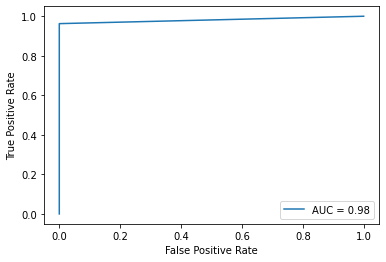

In [840]:
hgbc = HistGradientBoostingClassifier(learning_rate = hgbc_GS.best_params_['classifier__learning_rate'],max_depth= hgbc_GS.best_params_['classifier__max_depth'], max_iter=hgbc_GS.best_params_['classifier__max_iter'], loss=hgbc_GS.best_params_['classifier__loss'])

hgbc.fit(x_train, y_train)
y_pred_hgbc = hgbc.predict(x_test)

score(y_test, y_pred_hgbc)

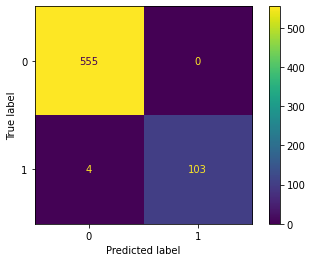

In [841]:
cm_hgbc = confusion_matrix(y_test, y_pred_hgbc)
cmd_hgbc = ConfusionMatrixDisplay(confusion_matrix=cm_hgbc,
                       display_labels=[0,1])

cmd_hgbc.plot()
plt.show()

### RandomForestClassifier

In [842]:
pipeline_rfc = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

In [843]:
n_estimators = [1,2,3,5,10,50,100,200,300]
criterion = ['gini', 'entropy']
max_depth = [5,10,14,18,22,24,30,50,100]


parameters_rfc = dict(classifier__n_estimators=n_estimators,
                  classifier__criterion=criterion,
                  classifier__max_depth=max_depth
                  )

In [844]:
rfc_GS = GridSearchCV(pipeline_rfc, parameters_rfc)
rfc_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [5, 10, 14, 18, 22, 24, 30,
                                                   50, 100],
                         'classifier__n_estimators': [1, 2, 3, 5, 10, 50, 100,
                                                      200, 300]})

In [845]:
pd.DataFrame.from_dict(rfc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
133,1.136291,0.008242,0.032713,3.989703e-04,entropy,24,200,"{'classifier__criterion': 'entropy', 'classifi...",0.974667,0.976000,0.976000,0.986649,0.979973,0.978658,0.004374,1
152,1.748695,0.070386,0.052060,7.007745e-03,entropy,50,300,"{'classifier__criterion': 'entropy', 'classifi...",0.973333,0.976000,0.976000,0.985314,0.977303,0.977590,0.004072,2
151,1.130542,0.015940,0.032101,4.059535e-04,entropy,50,200,"{'classifier__criterion': 'entropy', 'classifi...",0.973333,0.974667,0.977333,0.985314,0.977303,0.977590,0.004159,2
43,1.004341,0.007555,0.032699,3.931227e-04,gini,22,200,"{'classifier__criterion': 'gini', 'classifier_...",0.972000,0.976000,0.977333,0.983979,0.978638,0.977590,0.003892,4
61,1.001848,0.015989,0.032913,6.289914e-07,gini,30,200,"{'classifier__criterion': 'gini', 'classifier_...",0.970667,0.972000,0.974667,0.987984,0.981308,0.977325,0.006469,5


Accuracy: 0.9909365558912386
F1 score: 0.9711538461538461
Precision: 1.0
Recall: 0.9439252336448598
ROC AUC score: 0.9719626168224299


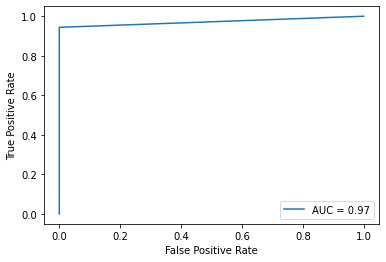

In [846]:
rfc = RandomForestClassifier(n_estimators=rfc_GS.best_params_['classifier__n_estimators'],criterion=rfc_GS.best_params_['classifier__criterion'],max_depth=rfc_GS.best_params_['classifier__max_depth'])

rfc.fit(x_train, y_train)
y_pred_rfc = rfc.predict(x_test)

score(y_test, y_pred_rfc)

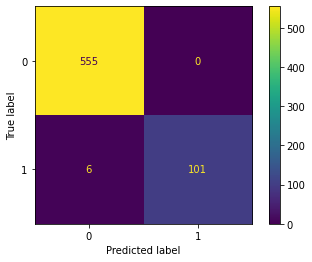

In [847]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
cmd_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,
                       display_labels=[0,1])

cmd_rfc.plot()
plt.show()

### Perceptron

In [848]:
pipeline_pe = Pipeline(steps=[
    ('classifier', Perceptron())
])

In [849]:
penalty = ['l2','l1','elasticnet']
alpha = [0.0001,0.0002,0.0003,0.0005]


parameters_pe = dict(classifier__penalty=penalty,
                  classifier__alpha=alpha)


In [850]:
pe_GS = GridSearchCV(pipeline_pe, parameters_pe)
pe_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', Perceptron())]),
             param_grid={'classifier__alpha': [0.0001, 0.0002, 0.0003, 0.0005],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet']})

In [851]:
pd.DataFrame.from_dict(pe_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.020799,0.004046,0.001675,0.000228,0.0003,elasticnet,"{'classifier__alpha': 0.0003, 'classifier__pen...",0.844000,0.832000,0.832000,0.837116,0.842457,0.837515,0.005049,1
0,0.005578,0.001003,0.002200,0.000977,0.0001,l2,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.838667,0.829333,0.833333,0.847797,0.833111,0.836448,0.006406,2
9,0.005259,0.000939,0.001628,0.000544,0.0005,l2,"{'classifier__alpha': 0.0005, 'classifier__pen...",0.838667,0.833333,0.837333,0.842457,0.823765,0.835111,0.006379,3
7,0.012861,0.004174,0.001818,0.000533,0.0003,l1,"{'classifier__alpha': 0.0003, 'classifier__pen...",0.846667,0.820000,0.828000,0.823765,0.846462,0.832979,0.011378,4
5,0.020707,0.006249,0.002035,0.000075,0.0002,elasticnet,"{'classifier__alpha': 0.0002, 'classifier__pen...",0.841333,0.856000,0.786667,0.803738,0.823765,0.822301,0.024957,5


Accuracy: 0.8383685800604229
F1 score: 0.0
Precision: 0.0
Recall: 0.0
ROC AUC score: 0.5


d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


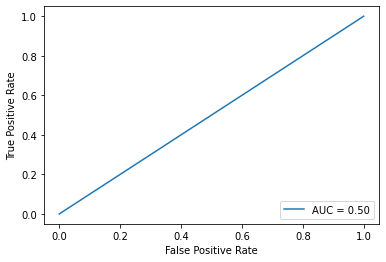

In [852]:
pe = Perceptron(penalty=pe_GS.best_params_['classifier__penalty'],alpha = pe_GS.best_params_['classifier__alpha'])

pe.fit(x_train, y_train)
y_pred_pe = pe.predict(x_test)

score(y_test, y_pred_pe)

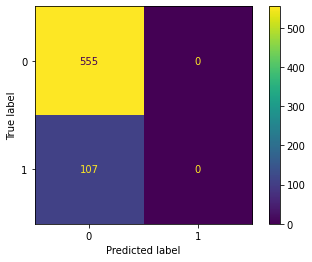

In [853]:
cm_pe = confusion_matrix(y_test, y_pred_pe)
cmd_pe = ConfusionMatrixDisplay(confusion_matrix=cm_pe,
                       display_labels=[0,1])

cmd_pe.plot()
plt.show()

### Logistic Regression

In [854]:
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

In [855]:
penalty = ['l2']
max_iter = [100,500,1000]


parameters_lr = dict(classifier__penalty = penalty,
                  classifier__max_iter = max_iter)

In [856]:
lr_GS = GridSearchCV(pipeline_lr, parameters_lr)
lr_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid={'classifier__max_iter': [100, 500, 1000],
                         'classifier__penalty': ['l2']})

In [857]:
pd.DataFrame.from_dict(lr_GS.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.048645,0.017014,0.002392,0.000794,100,l2,"{'classifier__max_iter': 100, 'classifier__pen...",0.852,0.858667,0.849333,0.855808,0.873164,0.857794,0.00832,1
1,0.033700,0.004511,0.001602,0.000494,500,l2,"{'classifier__max_iter': 500, 'classifier__pen...",0.852,0.858667,0.849333,0.855808,0.873164,0.857794,0.00832,1
2,0.031846,0.005120,0.001465,0.000400,1000,l2,"{'classifier__max_iter': 1000, 'classifier__pe...",0.852,0.858667,0.849333,0.855808,0.873164,0.857794,0.00832,1


Accuracy: 0.8580060422960725
F1 score: 0.29850746268656714
Precision: 0.7407407407407407
Recall: 0.18691588785046728
ROC AUC score: 0.5871516376189274


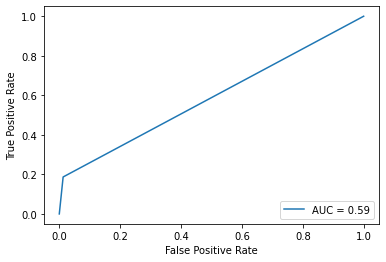

In [858]:
lr = LogisticRegression(penalty=lr_GS.best_params_['classifier__penalty'], max_iter=lr_GS.best_params_['classifier__max_iter'] )

lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

score(y_test, y_pred_lr)

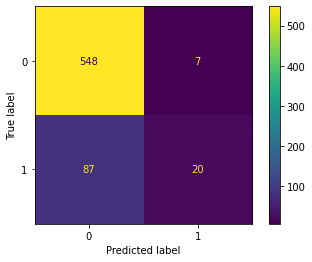

In [859]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cmd_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                       display_labels=[0,1])

cmd_lr.plot()
plt.show()

# Analyse des résultats

### DecisionTreeClassifier

In [860]:
cl_dtc = list(zip(x_train.columns, dtc.feature_importances_))
coefs_dtc = pd.DataFrame(cl_dtc, columns = ['Column', 'Coefs'])
coefs_dtc.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
9,YearsAtCompany,0.081967
35,avg_out_time,0.078650
31,EnvironmentSatisfaction,0.060754
7,TotalWorkingYears,0.059783
0,BusinessTravel,0.047845
3,MonthlyIncome,0.043909
34,avg_hours_worked,0.043140
4,NumCompaniesWorked,0.042571
5,PercentSalaryHike,0.041994
32,JobSatisfaction,0.041271


### HistGradientBoostingClassifier

L'analyse des résutats d'un HistGradientBoostingClassifier est complexe car ce modèle est capable de capturer des relations non-linéaires entre nos differentes données.
Il est donc difficile de comprendre comment ces relations non-linéaires contribuent à la prédiction du modèle.

### RandomForestClassifier

In [861]:
cl_rfc = list(zip(x_train.columns, rfc.feature_importances_))
coefs_rfc= pd.DataFrame(cl_rfc, columns = ['Column', 'Coefs'])
coefs_rfc.sort_values(by=['Coefs'], ascending=False)


,Column,Coefs
34,avg_hours_worked,0.089531
35,avg_out_time,0.086425
7,TotalWorkingYears,0.085624
3,MonthlyIncome,0.071515
9,YearsAtCompany,0.057217
1,DistanceFromHome,0.052730
5,PercentSalaryHike,0.046507
11,YearsWithCurrManager,0.045920
4,NumCompaniesWorked,0.041500
31,EnvironmentSatisfaction,0.038877


### Perceptron

In [862]:
cl_pe = list(zip(x_train.columns, pe.coef_[0]))
coefs_pe = pd.DataFrame(cl_pe, columns = ['Column', 'Coefs'])
coefs_pe.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
10,YearsSinceLastPromotion,3.268002
4,NumCompaniesWorked,1.234357
16,Education_Life Sciences,1.029141
34,avg_hours_worked,1.028537
35,avg_out_time,0.992718
26,Job_Research Director,0.769916
15,Education_Human Resources,0.459671
0,BusinessTravel,0.404322
27,Job_Research Scientist,0.171244
28,Job_Sales Executive,0.000000


### LogisticRegression

In [863]:
cl_lr = list(zip(x_train.columns, lr.coef_[0]))
coefs_lr = pd.DataFrame(cl_lr, columns = ['Column', 'Coefs'])
coefs_lr.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
10,YearsSinceLastPromotion,1.937502
0,BusinessTravel,1.452051
34,avg_hours_worked,1.092415
35,avg_out_time,1.081810
4,NumCompaniesWorked,0.897091
26,Job_Research Director,0.674109
15,Education_Human Resources,0.657634
28,Job_Sales Executive,0.437247
12,Department_HR,0.340091
5,PercentSalaryHike,0.294088


# Conclusion
<div id="cc"></div>

Le choix du modèle de machine learning dépend de nombreux facteurs tels que la taille et la qualité des données, le type de problème à résoudre et les objectifs de performance. Dans le cas présent, nous avons éliminé HistGradientBoostingClassifier en raison de son manque d'interprétabilité, et le perceptron ainsi que la régression logistique en raison de résultats inexploitables.

Finalement, le DecisionTreeClassifier a été choisi comme modèle car il est plus facile à comprendre que le RandomForestClassifier. Il est donc plus facile d'expliquer les relations possibles entre nos différentes données et donc de proposer des pistes d'amélioration pour réduire le turn over.

## Etudes pour HumanForYou

Dans cette partie, nous proposons plusieurs pistes d'amélioration pour aider HumanForYou à réduire 
son taux de turn-over et à améliorer la satisfaction des employés. Nos recommandations sont basées 
sur l'analyse des données fournies et les modèles développés dans le respect des principes éthiques

In [866]:
coefs_dtc.sort_values(by=['Coefs'], ascending=False).head(4)

,Column,Coefs
9,YearsAtCompany,0.081967
35,avg_out_time,0.078650
31,EnvironmentSatisfaction,0.060754
7,TotalWorkingYears,0.059783


### Opportunités de formation et de développement professionnel
Le nombre de jours de formation et les années depuis la dernière promotion (YearsSinceLastPromotion) sont des facteurs 
influençant le taux de turn-over. Il est essentiel d'offrir des opportunités de formation et de 
développement professionnel pour maintenir l'engagement des employés. HumanForYou pourrait 
mettre en place un programme de formation continue et un système de mentorat pour soutenir les 
employés dans leur évolution professionnelle.
### Amélioration de l'équilibre travail-vie personnelle
Les données montrent que le temps passé au travail (avg_hours_worked & avg_out_time) est un facteur important 
pour la satisfaction des employés. L'entreprise pourrait proposer des options de travail flexibles, 
comme le télétravail, des horaires ajustables ou la mise en place d'un système de crédit-temps pour 
encourager une meilleure conciliation entre la vie professionnelle et personnelle.
### Satisfaction de l'environnement de travail 
Les employés qui se sentent satisfaits de leur environnement de travail (EnvironmentSatisfaction) sont plus susceptibles de 
rester dans l'entreprise. HumanForYou devrait examiner les conditions de travail, les installations et 
les équipements pour s'assurer qu'ils sont bien adaptés aux besoins des employés. Des enquêtes 
régulières sur la qualité de vie au travail peuvent aider à identifier les domaines à améliorer.

En mettant en œuvre ces pistes d'amélioration, HumanForYou peut créer un environnement de 
travail plus attrayant et réduire le taux de turn-over. Il est important de suivre régulièrement 
l'efficacité de ces initiatives et d'ajuster les stratégies en conséquence, en tenant compte des retours 
des employés et des nouvelles informations issues de l'analyse des données